# **FORECASTING PRICE OF LETTUCE IN THE UK**
© **Explore Data Science Academy**

_Prepared by:_
- McMunashe Munemo
- Stanley Agbo
- Winfred Mutinda
- Colin Mburugu
- Dennis Gitari

## **TABLE OF CONTENTS**

[Introduction](#introduction)
- Problem Statement
- Data Description 
- Preliminary Activities
    - Importing Packages
    - Loading the Datasets
    
[Exploratory Data Analysis](#exploratory_data_analysis)

[Feature Engineering](#feature_engineering)
   - Data Pre-Processing and Visualisations For Time Series
   - Splitting the data into Train and Test Set
   - Run stationarity test
   - First Order Differencing
   - Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
   - Granger Causality test

[Model Forecasting](#modelling)


[Evaluate the Forecasts](#model_performance_comparison)


[Conclusion](#conclusion)



## **INTRODUCTION**

Lettuce (Lactuca sativa) is one of the world's most economically important leafy vegetables. It is one of the most popular salad crops and is well-known for its delicate, crispy texture and slightly bitter taste, as well as its fresh condition of milky juice. It is among the most widely grown salad vegetable crops because of its high demand. Lettuce is rich in vitamins as well as minerals such as calcium and iron. It is commonly served alone or with dressing as a salad with tomatoes, carrots, cucumbers, or other salad vegetables. 


The aim of this project is:
> Forecasting Lettuce prices in the UK to help retailers set their prices by creating a time series model


### **PROBLEM STATEMENT**

How has the increased cost of living affected lettuce prices?

### **DATA DESCRIPTION**

This project aims to forecast the price of iceberg lettuce in the UK using data collected by the Office of National Statistics (ONS). 

Features in the dataset:

>**Date**: 1988 - 2019 (monthly)

>**Price**: Currency is in Pound sterling 

>**Regions**: 13 regions were captured by the Office of National Statistics (ONS)




## **IMPORTING PACKAGES**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Library for creating pickle files of the models
import pickle

C:\Users\mac07\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\mac07\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## **LOADING THE DATASETS**

In [2]:
df = pd.read_stata("Lettuce App/data/5pct_sample_2019_10.dta")
db_date = pd.read_csv("Lettuce App/data/db_date.csv")

In [3]:
new_df = df.merge(db_date, on = 'date')

In [4]:
df1 = np.where(new_df['item'] == 250)
df1 = new_df.loc[df1]

In [5]:
ts = df1[['date2','price','region']]
ts.head()

,date2,price,region
141,01-12-2014,0.45,London
696,01-12-2014,0.49,South East
1726,01-12-2014,0.75,East Anglia
1727,01-12-2014,0.99,East Anglia
1728,01-12-2014,0.49,East Anglia


In [6]:
ts.rename(columns={'date2':'date'},inplace = True)

<ipython-input-6-9503c67a7705>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.rename(columns={'date2':'date'},inplace = True)


In [7]:
ts['date'] = pd.to_datetime(ts["date"],format="%d-%m-%Y") # Converted date string into datetime 

<ipython-input-7-5274adf849de>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['date'] = pd.to_datetime(ts["date"],format="%d-%m-%Y") # Converted date string into datetime


In [8]:
ts.head()

,date,price,region
141,2014-12-01,0.45,London
696,2014-12-01,0.49,South East
1726,2014-12-01,0.75,East Anglia
1727,2014-12-01,0.99,East Anglia
1728,2014-12-01,0.49,East Anglia


## DATA CLEANING 

In [9]:
#Removing duplicates
ts.drop_duplicates(keep = "first",inplace = True) #Keeps the first one and removes the duplicate 

<ipython-input-9-1d8ee09b90d4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts.drop_duplicates(keep = "first",inplace = True) #Keeps the first one and removes the duplicate


In [10]:
ts.duplicated().sum() # checking if there are duplicates 

0

In [11]:
ts.shape

(4159, 3)

In [12]:
ts.head()

,date,price,region
141,2014-12-01,0.45,London
696,2014-12-01,0.49,South East
1726,2014-12-01,0.75,East Anglia
1727,2014-12-01,0.99,East Anglia
1728,2014-12-01,0.49,East Anglia


In [13]:
list(ts['region'].unique())

['London',
 'South East',
 'East Anglia',
 'East Midlands',
 'Yorkshire & Humber',
 'North',
 'Wales',
 'Scotland',
 'North West',
 'South West',
 'West Midlands',
 'Northern Ireland',
 99]

After listing all the regions captured by the Office of National Statistics (ONS), the aim is to manipulate the data to show prices per region. The steps taken are firstly to make the date column an index because the data is time series data.  Secondly extract the regions by creating multiple dataframe then finally merging all dataframes using an outer join.

## **Feature Engineering**

Filtering the initial dataframe where region is London to obtain the first dataframe which is ts1.

In [14]:
ts1 = np.where(ts['region'] == 'London') # London dataframe 
ts1 = ts.iloc[ts1]

In [15]:
ts1.shape

(447, 3)

In [16]:
ts1['date'].drop_duplicates(keep = 'first',inplace = True)

<ipython-input-16-9b7c9933f83c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts1['date'].drop_duplicates(keep = 'first',inplace = True)


In [17]:
ts1.shape

(447, 3)

Notice the numbe of rows are still the same.

In [18]:
ts1['date'].duplicated().sum()

182

The duplicates are still present in the date column. The aim is to make the date column unique which will become the index of the final dataframe.

In [19]:
ts1.head()

,date,price,region
141,2014-12-01,0.45,London
5163,2015-03-01,0.89,London
5164,2015-03-01,0.55,London
15677,2015-05-01,0.49,London
21018,2016-02-01,0.49,London


In [20]:
ts2 = ts1.groupby('date').mean()

In the initial dataframe each region had different shops, which had different prices on the same date. Thus causing the duplicates. Instead of dropping all the duplicates and losing a lot of data, groupby is used. Grouping all the prices by date and taking the average price will create the date index which will be unique. 

In [21]:
ts2.shape # Confirming the 182 duplicates have been removed.

(265, 1)

In [22]:
ts2.head()

,price
date,
1989-07-01,0.690000
1989-11-01,0.840000
1989-12-01,0.990000
1990-01-01,0.633333
1990-03-01,0.980000


These are all the average prices for the London region. The plan is to rename the price column name to London for the final dataframe

In [23]:
ts2['region'] = 'London'

In [24]:
ts2

,price,region
date,,
1989-07-01,0.690000,London
1989-11-01,0.840000,London
1989-12-01,0.990000,London
1990-01-01,0.633333,London
1990-03-01,0.980000,London
...,...,...
2019-04-01,0.773333,London
2019-05-01,0.600000,London
2019-06-01,0.675000,London


In [25]:
ts3 = np.where(ts['region'] == 'North') #North dataframe 
ts3 = ts.iloc[ts3]

In [26]:
ts3['date'].duplicated().sum() # date column has duplicates 

50

In [27]:
ts4 = ts3.groupby('date').mean()

In [28]:
ts4.shape

(185, 1)

In [29]:
ts4['region']='North'

In [30]:
ts4

,price,region
date,,
1989-01-01,0.790,North
1989-02-01,0.650,North
1989-04-01,0.670,North
1989-05-01,0.565,North
1989-08-01,0.450,North
...,...,...
2018-12-01,0.650,North
2019-01-01,0.625,North
2019-03-01,0.535,North


In [31]:
new_ts = ts2.merge(ts4,how = 'outer' ,left_index = True,right_index = True) # Used an outer join to avoid data loss 
new_ts

,price_x,region_x,price_y,region_y
date,,,,
1989-01-01,NaN,NaN,0.790,North
1989-02-01,NaN,NaN,0.650,North
1989-04-01,NaN,NaN,0.670,North
1989-05-01,NaN,NaN,0.565,North
1989-07-01,0.690000,London,NaN,NaN
...,...,...,...,...
2019-04-01,0.773333,London,0.600,North
2019-05-01,0.600000,London,NaN,NaN
2019-06-01,0.675000,London,0.600,North


In [32]:
new_ts.rename(columns = {'price_x':'London','price_y':'North'},inplace = True)

In [33]:
new_ts.drop(columns = ['region_x','region_y'],inplace = True)

In [34]:
new_ts

,London,North
date,,
1989-01-01,NaN,0.790
1989-02-01,NaN,0.650
1989-04-01,NaN,0.670
1989-05-01,NaN,0.565
1989-07-01,0.690000,NaN
...,...,...
2019-04-01,0.773333,0.600
2019-05-01,0.600000,NaN
2019-06-01,0.675000,0.600


Notice the price columns have been drop and renamed respectively. The same steps are going to be followed for all the remaining regions.

In [35]:
ts5 = np.where(ts['region'] == 'South East')
ts5 = ts.iloc[ts5]
ts6 = ts5.groupby('date').mean()


In [36]:
ts6.rename(columns ={'price':"South East"},inplace= True)

In [37]:
new_ts1 = new_ts.merge(ts6,how = 'outer' ,left_index = True,right_index = True)
new_ts1

,London,North,South East
date,,,
1988-02-01,NaN,NaN,0.690000
1988-03-01,NaN,NaN,0.600000
1988-04-01,NaN,NaN,0.990000
1988-05-01,NaN,NaN,0.700000
1988-06-01,NaN,NaN,0.737500
...,...,...,...
2019-04-01,0.773333,0.6,0.556667
2019-05-01,0.600000,NaN,0.760000
2019-06-01,0.675000,0.6,0.695000


In [38]:
ts7 = np.where(ts['region'] == 'East Anglia')
ts7 = ts.iloc[ts7]
ts8 = ts7.groupby('date').mean()

In [39]:
ts8.rename(columns ={'price':"East Anglia"},inplace= True)

In [40]:
new_ts2 = new_ts1.merge(ts8,how = 'outer' ,left_index = True,right_index = True)
new_ts2

,London,North,South East,East Anglia
date,,,,
1988-02-01,NaN,NaN,0.690000,0.695
1988-03-01,NaN,NaN,0.600000,NaN
1988-04-01,NaN,NaN,0.990000,NaN
1988-05-01,NaN,NaN,0.700000,0.750
1988-06-01,NaN,NaN,0.737500,NaN
...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN
2019-05-01,0.600000,NaN,0.760000,0.890
2019-06-01,0.675000,0.6,0.695000,0.650


In [41]:
ts9 = np.where(ts['region'] == 'East Midlands')
ts9 = ts.iloc[ts9]
ts10 = ts9.groupby('date').mean()

In [42]:
ts10.rename(columns ={'price':"East Midlands"},inplace= True)

In [43]:
new_ts3 = new_ts2.merge(ts10,how = 'outer' ,left_index = True,right_index = True)
new_ts3

,London,North,South East,East Anglia,East Midlands
date,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN
1988-03-01,NaN,NaN,0.600000,NaN,NaN
1988-04-01,NaN,NaN,0.990000,NaN,0.550000
1988-05-01,NaN,NaN,0.700000,0.750,0.800000
1988-06-01,NaN,NaN,0.737500,NaN,0.490000
...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667


In [44]:
ts11 = np.where(ts['region'] == 'Yorkshire & Humber')
ts11 = ts.iloc[ts11]
ts12 = ts11.groupby('date').mean()
ts12.rename(columns ={'price':"Yorkshire & Humber"},inplace= True)
new_ts4 = new_ts3.merge(ts12,how = 'outer' ,left_index = True,right_index = True)
new_ts4

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber
date,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN
...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000


In [45]:
ts13 = np.where(ts['region'] == 'Wales')
ts13 = ts.iloc[ts13]
ts14= ts13.groupby('date').mean()
ts14.rename(columns ={'price':'Wales'},inplace= True)
new_ts5 = new_ts4.merge(ts14,how = 'outer' ,left_index = True,right_index = True)
new_ts5

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales
date,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN
...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60


In [46]:
ts15 = np.where(ts['region'] == 'Scotland')
ts15 = ts.iloc[ts15]
ts16= ts15.groupby('date').mean()
ts16.rename(columns ={'price':'Scotland'},inplace= True)
new_ts6 = new_ts5.merge(ts16,how = 'outer' ,left_index = True,right_index = True)
new_ts6

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales,Scotland
date,,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN,0.950
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80,0.725
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN,NaN
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99,0.550
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85,0.590
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60,0.640


In [47]:
ts17 = np.where(ts['region'] == 'North West')
ts17 = ts.iloc[ts17]
ts18= ts17.groupby('date').mean()
ts18.rename(columns ={'price':'North West'},inplace= True)
new_ts7 = new_ts6.merge(ts18,how = 'outer' ,left_index = True,right_index = True)
new_ts7

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales,Scotland,North West
date,,,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN,0.950,1.200
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80,0.725,NaN
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN,NaN,0.600
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN,NaN
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN,NaN,0.590
...,...,...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99,0.550,0.795
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85,0.590,0.950
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60,0.640,0.950


In [48]:
ts19 = np.where(ts['region'] == 'South West')
ts19 = ts.iloc[ts19]
ts20= ts19.groupby('date').mean()
ts20.rename(columns ={'price':'South West'},inplace= True)
new_ts8 = new_ts7.merge(ts20,how = 'outer' ,left_index = True,right_index = True)
new_ts8

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales,Scotland,North West,South West
date,,,,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN,0.950,1.200,NaN
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80,0.725,NaN,NaN
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN,NaN,0.600,NaN
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN,NaN,0.740000
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN,NaN,0.590,0.800000
...,...,...,...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99,0.550,0.795,0.653333
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85,0.590,0.950,0.250000
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60,0.640,0.950,0.650000


In [49]:
ts21 = np.where(ts['region'] == 'West Midlands')
ts21 = ts.iloc[ts21]
ts22= ts21.groupby('date').mean()
ts22.rename(columns ={'price':'West Midlands'},inplace= True)
new_ts9 = new_ts8.merge(ts22,how = 'outer' ,left_index = True,right_index = True)
new_ts9

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales,Scotland,North West,South West,West Midlands
date,,,,,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN,0.950,1.200,NaN,NaN
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80,0.725,NaN,NaN,NaN
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN,NaN,0.600,NaN,0.54
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN,NaN,0.740000,0.79
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN,NaN,0.590,0.800000,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99,0.550,0.795,0.653333,0.89
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85,0.590,0.950,0.250000,0.60
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60,0.640,0.950,0.650000,0.70


In [50]:
ts23 = np.where(ts['region'] == 'Northern Ireland')
ts23 = ts.iloc[ts23]
ts24= ts23.groupby('date').mean()
ts24.rename(columns ={'price':'Northern Ireland'},inplace= True)
new_ts10 = new_ts9.merge(ts24,how = 'outer' ,left_index = True,right_index = True)
new_ts10

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales,Scotland,North West,South West,West Midlands,Northern Ireland
date,,,,,,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN,0.950,1.200,NaN,NaN,NaN
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80,0.725,NaN,NaN,NaN,NaN
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN,NaN,0.600,NaN,0.54,NaN
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN,NaN,0.740000,0.79,NaN
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN,NaN,0.590,0.800000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99,0.550,0.795,0.653333,0.89,0.800
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85,0.590,0.950,0.250000,0.60,0.745
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60,0.640,0.950,0.650000,0.70,0.650


In [51]:
ts25 = np.where(ts['region'] == 99)
ts25 = ts.iloc[ts25]
ts26= ts25.groupby('date').mean()
ts26.rename(columns ={'price':99},inplace= True)
new_ts11 = new_ts10.merge(ts26,how = 'outer' ,left_index = True,right_index = True)
new_ts11

,London,North,South East,East Anglia,East Midlands,Yorkshire & Humber,Wales,Scotland,North West,South West,West Midlands,Northern Ireland,99
date,,,,,,,,,,,,,
1988-02-01,NaN,NaN,0.690000,0.695,NaN,0.776667,NaN,0.950,1.200,NaN,NaN,NaN,NaN
1988-03-01,NaN,NaN,0.600000,NaN,NaN,0.845000,0.80,0.725,NaN,NaN,NaN,NaN,0.64
1988-04-01,NaN,NaN,0.990000,NaN,0.550000,NaN,NaN,NaN,0.600,NaN,0.54,NaN,0.65
1988-05-01,NaN,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN,NaN,0.740000,0.79,NaN,NaN
1988-06-01,NaN,NaN,0.737500,NaN,0.490000,NaN,NaN,NaN,0.590,0.800000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-04-01,0.773333,0.6,0.556667,NaN,0.625000,0.595000,0.99,0.550,0.795,0.653333,0.89,0.800,NaN
2019-05-01,0.600000,NaN,0.760000,0.890,0.650000,0.650000,0.85,0.590,0.950,0.250000,0.60,0.745,NaN
2019-06-01,0.675000,0.6,0.695000,0.650,0.636667,0.600000,0.60,0.640,0.950,0.650000,0.70,0.650,NaN


After merging all the dataframes this was the final outcome. Notice that there are a lot of NaN  values, data cleaning needs to be done.

In [52]:
df_ts = new_ts11

In [53]:
df_ts.info() # summary report of the data 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 379 entries, 1988-02-01 to 2019-08-01
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   London              265 non-null    float32
 1   North               185 non-null    float32
 2   South East          300 non-null    float32
 3   East Anglia         222 non-null    float32
 4   East Midlands       216 non-null    float32
 5   Yorkshire & Humber  248 non-null    float32
 6   Wales               179 non-null    float32
 7   Scotland            227 non-null    float32
 8   North West          268 non-null    float32
 9   South West          252 non-null    float32
 10  West Midlands       241 non-null    float32
 11  Northern Ireland    122 non-null    float32
 12  99                  35 non-null     float32
dtypes: float32(13)
memory usage: 22.2 KB


The threshold chosen for dealing with the missing values was 50%. If a column had more than 50% missing values it was dropped.

In [54]:
#Dropping columns with more than half missing values
cols = ['North','Wales','Northern Ireland',99]

In [55]:
df_ts.drop(columns = cols,inplace = True)

In [56]:
df_ts.asfreq(freq = 'M',method = 'bfill') # Time series method to ensure that the frequency is monthly

,London,South East,East Anglia,East Midlands,Yorkshire & Humber,Scotland,North West,South West,West Midlands
date,,,,,,,,,
1988-02-29,NaN,0.600000,NaN,NaN,0.845000,0.725,NaN,NaN,NaN
1988-03-31,NaN,0.990000,NaN,0.550000,NaN,NaN,0.600,NaN,0.54
1988-04-30,NaN,0.700000,0.750,0.800000,NaN,NaN,NaN,0.740000,0.79
1988-05-31,NaN,0.737500,NaN,0.490000,NaN,NaN,0.590,0.800000,NaN
1988-06-30,NaN,NaN,0.520,NaN,NaN,NaN,NaN,0.555000,NaN
...,...,...,...,...,...,...,...,...,...
2019-03-31,0.773333,0.556667,NaN,0.625000,0.595000,0.550,0.795,0.653333,0.89
2019-04-30,0.600000,0.760000,0.890,0.650000,0.650000,0.590,0.950,0.250000,0.60
2019-05-31,0.675000,0.695000,0.650,0.636667,0.600000,0.640,0.950,0.650000,0.70


The method 'bfill' is incase a month was missing it uses the values of the previous month as a filler.

In [57]:
df_ts = df_ts.fillna(df_ts.mean()) # filling null values with mean of that specific column 

In [58]:
df_ts.head()

,London,South East,East Anglia,East Midlands,Yorkshire & Humber,Scotland,North West,South West,West Midlands
date,,,,,,,,,
1988-02-01,0.711711,0.6900,0.695000,0.727924,0.776667,0.950000,1.200000,0.710023,0.716743
1988-03-01,0.711711,0.6000,0.739028,0.727924,0.845000,0.725000,0.700045,0.710023,0.716743
1988-04-01,0.711711,0.9900,0.739028,0.550000,0.706472,0.697074,0.600000,0.710023,0.540000
1988-05-01,0.711711,0.7000,0.750000,0.800000,0.706472,0.697074,0.700045,0.740000,0.790000
1988-06-01,0.711711,0.7375,0.739028,0.490000,0.706472,0.697074,0.590000,0.800000,0.716743


In [60]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 379 entries, 1988-02-01 to 2019-08-01
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   London              379 non-null    float32
 1   South East          379 non-null    float32
 2   East Anglia         379 non-null    float32
 3   East Midlands       379 non-null    float32
 4   Yorkshire & Humber  379 non-null    float32
 5   Scotland            379 non-null    float32
 6   North West          379 non-null    float32
 7   South West          379 non-null    float32
 8   West Midlands       379 non-null    float32
dtypes: float32(9)
memory usage: 16.3 KB


## Data Pre-Processing and Visualisations For Time Series

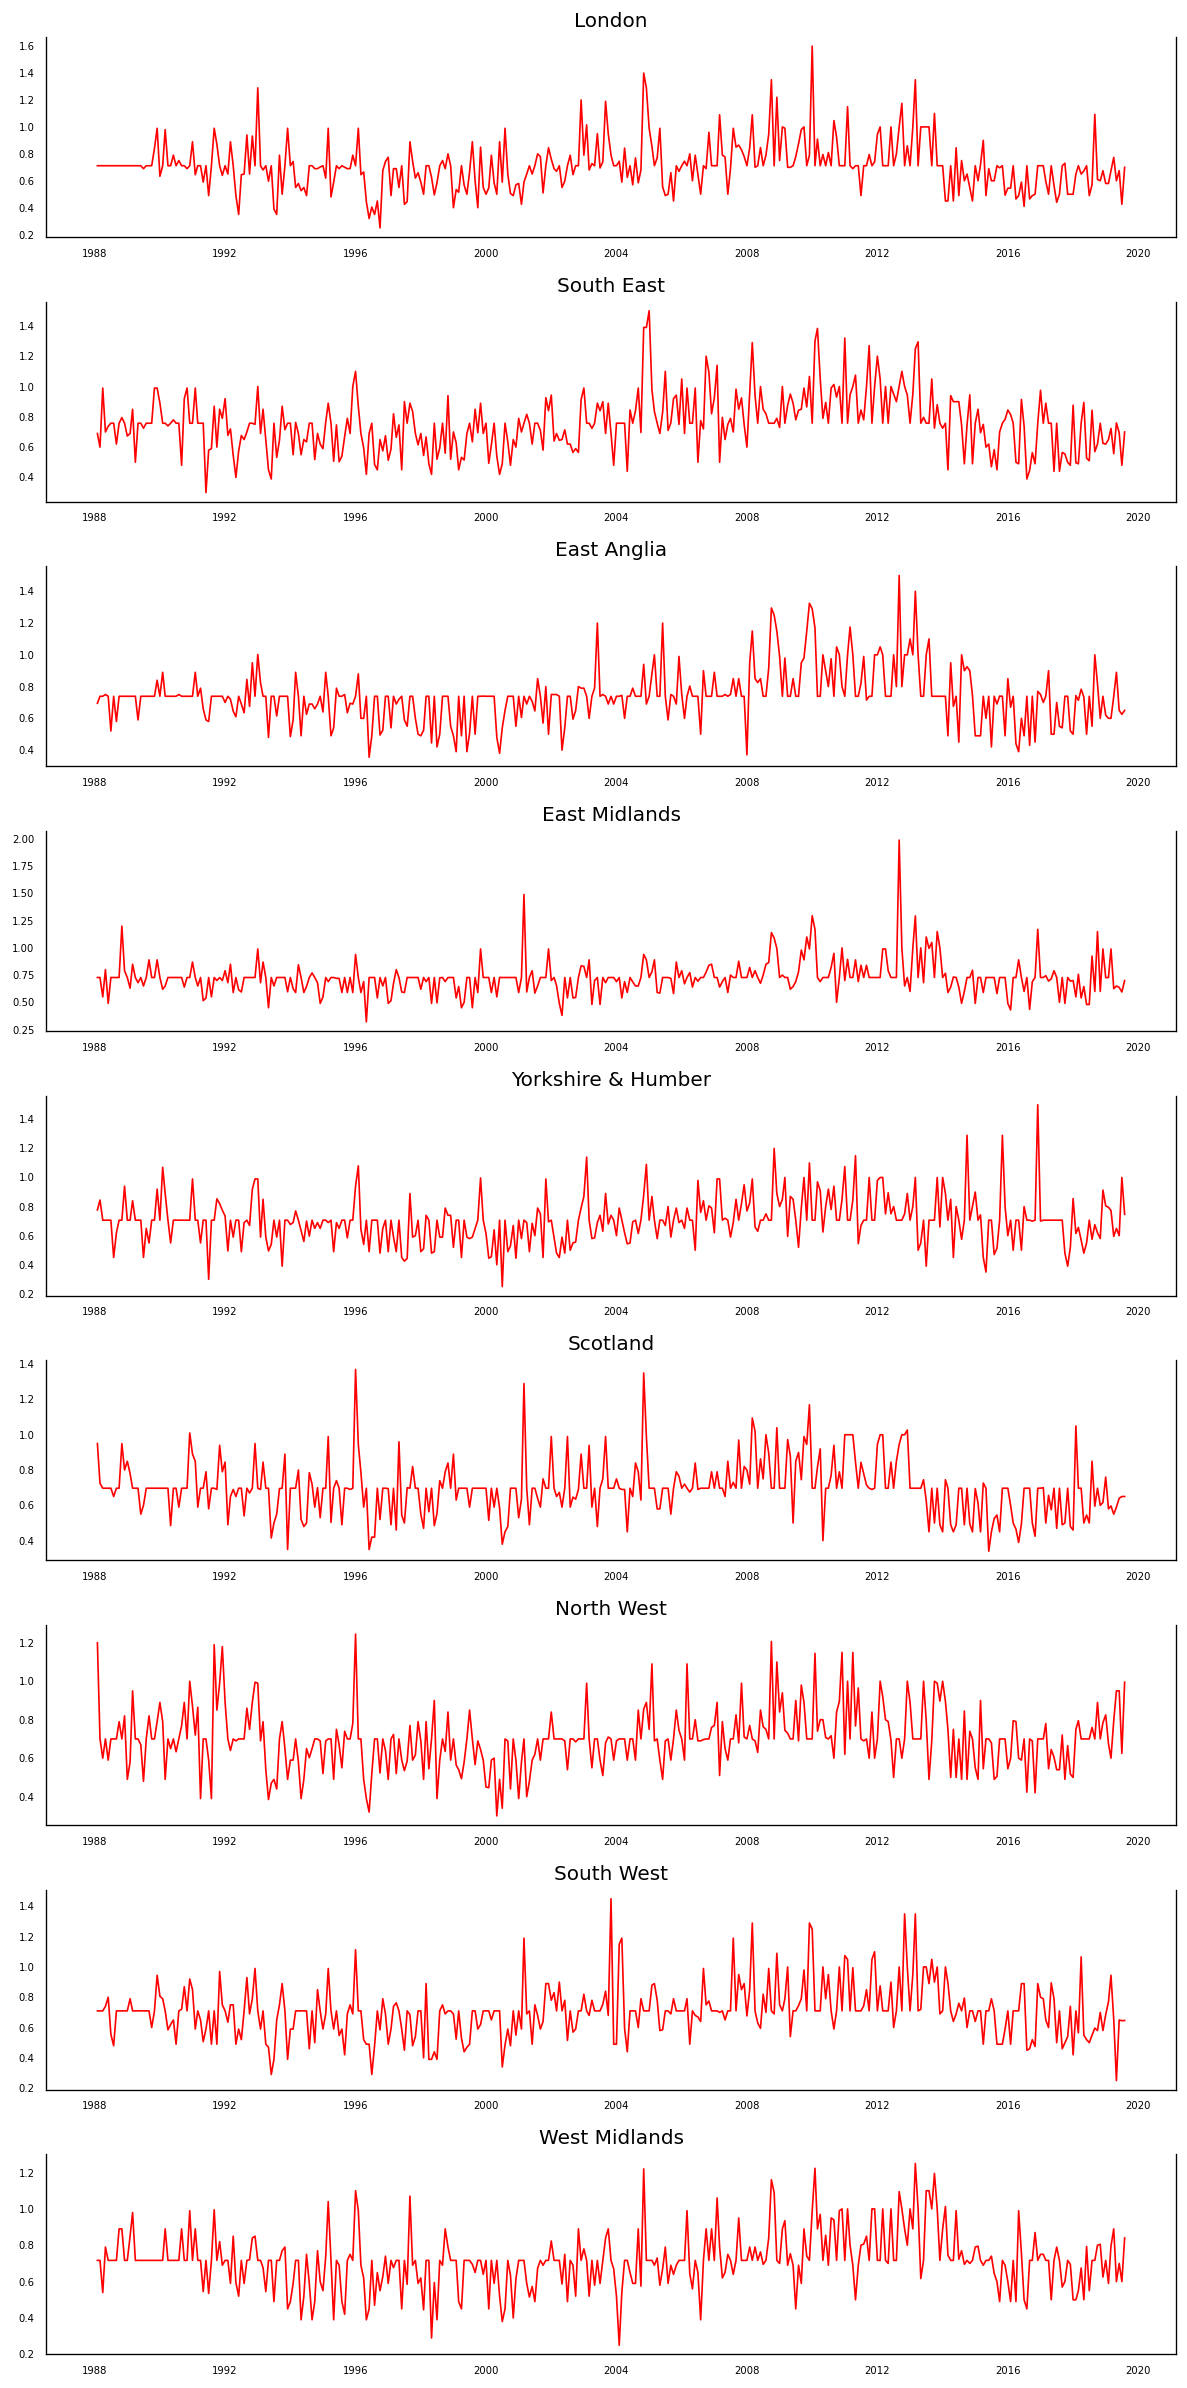

In [61]:
fig, axes = plt.subplots(nrows=9, ncols=1, dpi=120, figsize=(10,20))
for i, ax in enumerate(axes.flatten()):
    data = df_ts[df_ts.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df_ts.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Each time series appears to have a constant mean and a constant trend through out the years but got varying amplitudes or variances.Some years seem to have very high prices compared to other years,while others have extremely low prices compared to other years in all regions.Thus a stationarity test needed to all time series are stationary.

In [62]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12 # can use any number of lags 
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df_ts, variables = df_ts.columns)   

,London_x,South East_x,East Anglia_x,East Midlands_x,Yorkshire & Humber_x,Scotland_x,North West_x,South West_x,West Midlands_x
London_y,1.0000,0.0000,0.0003,0.0000,0.0284,0.0000,0.0054,0.0000,0.0003
South East_y,0.0000,1.0000,0.0000,0.0000,0.0008,0.0114,0.0306,0.0001,0.0000
East Anglia_y,0.0000,0.0003,1.0000,0.0032,0.0035,0.0000,0.0004,0.0001,0.0144
East Midlands_y,0.0004,0.0018,0.0000,1.0000,0.0071,0.0333,0.0057,0.0003,0.0000
Yorkshire & Humber_y,0.0011,0.0000,0.0000,0.0009,1.0000,0.0321,0.0000,0.0007,0.0000
Scotland_y,0.0014,0.0000,0.0000,0.0079,0.0003,1.0000,0.0044,0.0048,0.0028
North West_y,0.0000,0.0000,0.0000,0.0126,0.0010,0.0012,1.0000,0.0005,0.0020
South West_y,0.0000,0.0000,0.0000,0.0000,0.0012,0.0141,0.0008,1.0000,0.0000
West Midlands_y,0.0000,0.0001,0.0000,0.0000,0.0165,0.0251,0.0043,0.0000,1.0000


Check Granger Causality of all possible combinations of the Time series.
The rows are the response variable, columns are predictors. The values in the table 
  are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    
Looking at the P-Values in the above table, you can pretty much observe that all the variables (time series) in the system are interchangeably causing each other.

This makes this system of multi time series a good candidate for using VAR models to forecast.

## Splitting the data into Train and Test Set

In [63]:
nobs = 12
df_train, df_test = df_ts[0:-nobs], df_ts[-nobs:] # Using the last 12 months of our data as the test set

In [64]:
df_test.shape

(12, 9)

## Run stationarity test

In [65]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

A stationary time series is one whose characteristics like mean and variance does not change over time.
Since the VAR model requires the time series you want to forecast to be stationary, it is customary to check all the time series in the system for stationarity.
If a series is found to be non-stationary, you make it stationary by differencing the series once and repeat the test again until it becomes stationary.
Here we used the Augmented Dickey - Fuller Test (ADF test) to confirm the time series is staionary

In [66]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "London" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4373
 No. Lags Chosen       = 12
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.1315. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "South East" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2007
 No. Lags Chosen       = 12
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.206. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "East Anglia" 
    -----------------------------------------------
 Null Hypothesis: Da

### First Order Differencing

In [67]:
df_differenced = df_train.diff().dropna()

Since, differencing reduces the length of the series by 1 and since all the time series has to be of the same length, you need to difference all the series in the system if you choose to difference at all.

In [68]:
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "London" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.3431
 No. Lags Chosen       = 11
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "South East" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -10.159
 No. Lags Chosen       = 11
 Critical value 1%     = -3.449
 Critical value 5%     = -2.87
 Critical value 10%    = -2.571
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "East Anglia" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance 

### Auto Correlation Plots

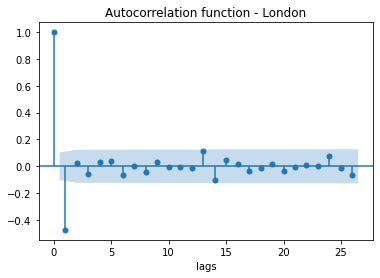

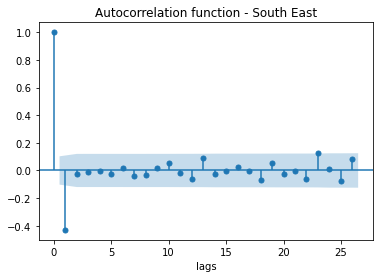

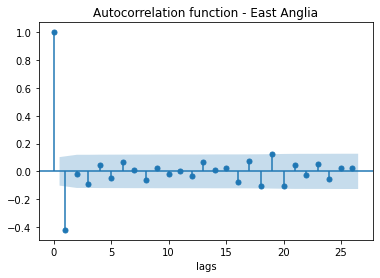

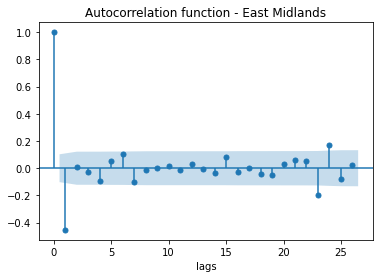

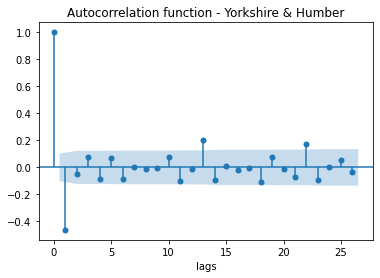

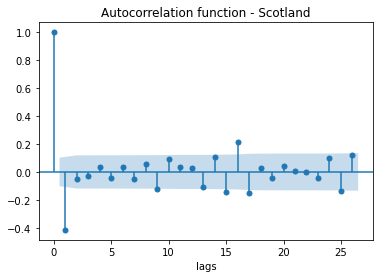

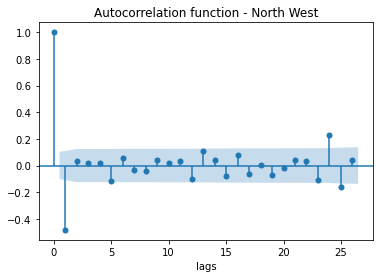

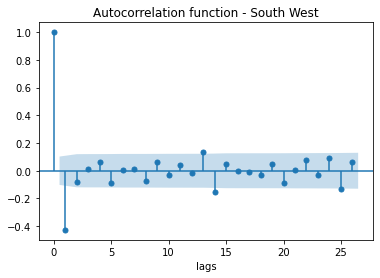

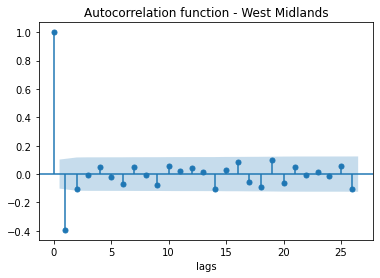

In [69]:
for col in df_differenced.columns:
    plot_acf(df_differenced[col],title='Autocorrelation function - {}'.format(col))
    plt.xlabel('lags')
    plt.show()
    

After performing differencing and ensuring that all the variables pass the stationarity test, we plot auto correlation plots of each time series variable to ensure no series is a random walk process.That is, every series should be correlated with at least one of its lagged values for it to be fit for prediction.

### Fitting the Vector Auto Regression Model

In [70]:
model = VAR(df_differenced)

C:\Users\mac07\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [71]:
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,-30.00,-29.90,9.392e-14,-29.96
1,-32.00,-31.02*,1.264e-14,-31.61
2,-32.75,-30.88,6.017e-15,-32.00
3,-33.12,-30.37,4.145e-15,-32.02*
4,-33.17,-29.53,3.941e-15,-31.73
5,-33.18,-28.66,3.931e-15,-31.38
6,-33.22,-27.80,3.843e-15*,-31.06
7,-33.22*,-26.92,3.885e-15,-30.71
8,-33.20,-26.02,4.020e-15,-30.34
9,-33.22,-25.15,4.058e-15,-30.01


Training the Vector Auto Regression model then using the select_order method to pick the order that gives a model with least AIC which is highlighted with an asterisk.
Though the usual practice is to look at the AIC, you can also check other best fit comparison estimates of BIC, FPE and HQIC.
In this case, the selected order is 7

In [72]:
model_fitted = model.fit(7)

Fitting the model with the selected order

In [73]:
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     17:29:47
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -27.0591
Nobs:                     359.000    HQIC:                  -30.8121
Log likelihood:           1966.92    FPE:                3.60987e-15
AIC:                     -33.2898    Det(Omega_mle):     8.24666e-16
--------------------------------------------------------------------
Results for equation London
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.000938         0.008651           -0.108           0.914
L1.London                    -0.789324         0.061360          -12.864           0.000
L1.South East              

### Residual Analysis

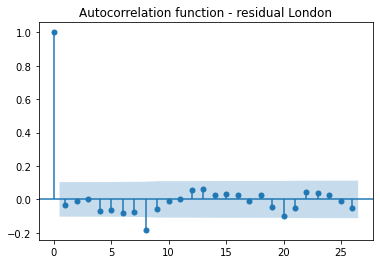

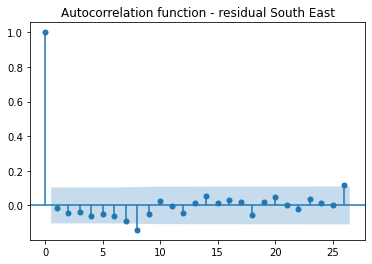

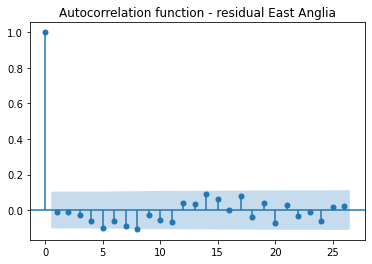

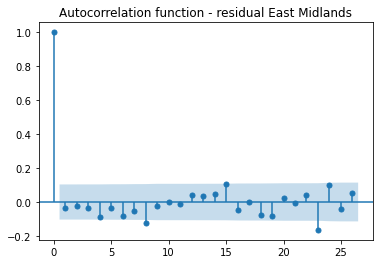

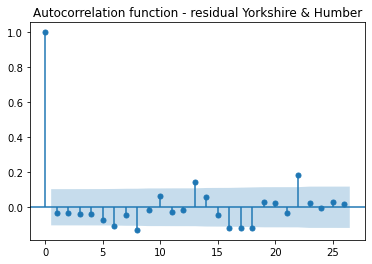

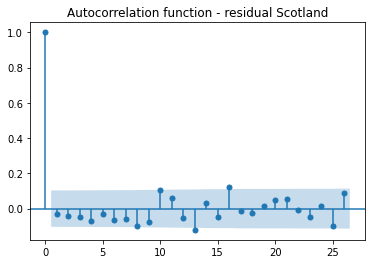

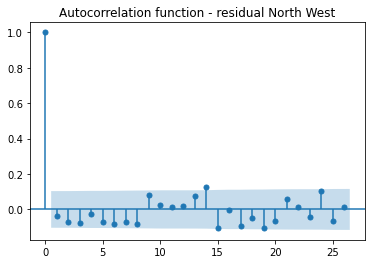

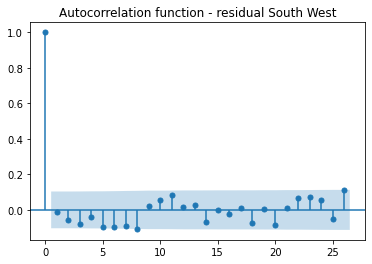

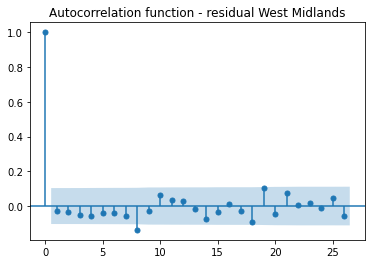

In [74]:
#Checking the presence of auto correlations in the residuals
for col in df_differenced.columns:
    plot_acf(model_fitted.resid[col],title='Autocorrelation function - residual {}'.format(col))

Checking whether there is any auto correlation in the residuals.Presence of auto correlation indicates there might be a pattern that our model has not captured.In this case no auto correlation in different variables thus all residuals in our variables are random processes

### Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

In [75]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ':', round(val, 2))

London : 2.07
South East : 2.02
East Anglia : 2.02
East Midlands : 2.05
Yorkshire & Humber : 2.07
Scotland : 2.05
North West : 2.07
South West : 2.03
West Midlands : 2.05


Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors).
If there is any correlation left in the residuals, then, there is some pattern in the time series that is still left to be explained by the model. In that case, the typical course of action is to either increase the order of the model or induce more predictors into the system or look for a different algorithm to model the time series.

### Granger Causality test

In [76]:
from itertools import combinations

treshold = 0.05


# Check if the lags of a quantity help predict its current value 
for quant in df_differenced.columns:
    
    causality = model_fitted.test_causality(quant, quant, kind='f')

    if causality.pvalue < treshold:
        print('{} lags might Granger-cause its current value (NULL HP rejected - pval = {:.4f})'.format(quant, causality.pvalue))
        print('---')

causally_related = []
        
# Check if one quantity causes the other
for quantA, quantB in combinations(df_differenced.columns,2):
    
    bidirectional = [(quantA,quantB),(quantB,quantA)]
    
    for caused, causing in bidirectional:
    
        causality = model_fitted.test_causality(caused, causing, kind='f')
        
        if causality.pvalue < treshold:
            print('{} might Granger-cause {} (NULL HP rejected - pval = {:.4f})'.format(causing, caused, causality.pvalue))
            print('---')
            causally_related.append((causing, caused))
            

London lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
South East lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
East Anglia lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
East Midlands lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
Yorkshire & Humber lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
Scotland lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
North West lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
South West lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
West Midlands lags might Granger-cause its current value (NULL HP rejected - pval = 0.0000)
---
East Midlands might Granger-cause London (NULL HP rejected - pval = 0.0002)
---
London might Granger-cause North West (NULL HP rejected - pval = 0.0101)
-

The Granger casuality test is ran again after fitting the model. This is done to check if the previous values of a region can be used to predict the future values of that region or if the previous values of region can be used to forecast for another region. 

### Model Forecasting

In order to forecast, the VAR model expects up to the lag order number of observations from the past data.

This is because, the terms in the VAR model are essentially the lags of the various time series in the dataset, so you need to provide it as many of the previous values as indicated by the lag order used by the model.

In [77]:
lag_order = model_fitted.k_ar # getting number of lags 

In [78]:
lag_order

7

In [79]:
# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[ 1.4999998e-01, -3.8000000e-01,  2.4333334e-01, -1.4999998e-01,
        -2.3999995e-01,  5.8999997e-01,  2.5000000e-01,  2.9000005e-01,
         0.0000000e+00],
       [ 6.1710894e-02, -6.6666603e-03, -2.9999971e-02,  2.0749998e-01,
         4.1666627e-02, -3.5292590e-01,  4.5000017e-02, -1.4500004e-01,
         5.0000012e-02],
       [-6.1710894e-02,  2.6778740e-01,  6.9999933e-02, -2.1749997e-01,
        -8.6666644e-02,  0.0000000e+00, -9.5000029e-02,  5.0166661e-01,
         1.2499994e-01],
       [ 2.2500038e-02,  1.3721257e-01, -4.8333287e-02,  1.0499996e-01,
        -9.0000004e-02, -1.9707406e-01,  4.4643879e-05, -5.1666659e-01,
        -1.7499995e-01],
       [ 3.9210856e-02, -3.6833334e-01, -2.3500001e-01, -1.6499999e-01,
         7.0000023e-02,  4.5000017e-02,  0.0000000e+00, -3.0000031e-02,
         2.9333335e-01],
       [-2.2171086e-01, -1.6666651e-02,  2.3902804e-01,  0.0000000e+00,
         1.5647179e-01, -4.5000017e-02,  0.0000000e+00, -1.9999981e-02,
        -2.

In [80]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df_ts.index[-nobs:], columns=df_ts.columns + '_1d')
df_forecast

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d
date,,,,,,,,,
2018-09-01,0.126954,-0.252835,0.147947,-0.138141,0.172843,-0.256088,0.034978,0.050883,-0.136500
2018-10-01,-0.130692,0.129885,-0.083905,-0.198083,-0.138605,0.183363,-0.192802,0.026532,0.006611
2018-11-01,0.032623,-0.138359,0.143744,0.078766,-0.063655,-0.217221,0.126525,0.041298,-0.001856
2018-12-01,-0.137630,0.092288,-0.133185,-0.089228,0.022785,0.162436,0.009874,-0.123073,0.063829
2019-01-01,0.276597,0.013385,0.089571,0.140269,0.117354,-0.103841,-0.002070,0.091668,-0.029781
2019-02-01,-0.053452,0.032387,-0.032757,-0.023490,-0.046144,0.002846,-0.076482,-0.095771,0.104522
2019-03-01,-0.106144,0.003270,-0.009016,0.006097,-0.054856,0.049785,0.060711,0.073397,-0.063621
2019-04-01,0.016503,-0.040383,-0.054156,-0.040955,0.047898,0.038018,0.032358,-0.017525,-0.019468
2019-05-01,0.016881,-0.026204,0.051443,-0.008555,0.047934,-0.061525,-0.027369,0.024113,-0.061344


The forecasts are generated but it is on the scale of the training data used by the model. So, to bring it back up to its original scale, you need to de-difference it as many times you had differenced the original input data.

In this case it is one time.

### Invert the transformation to get the real forecast

In [81]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        else:
            df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [82]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False) 

In [83]:
df_ts.columns

Index(['London', 'South East', 'East Anglia', 'East Midlands',
       'Yorkshire & Humber', 'Scotland', 'North West', 'South West',
       'West Midlands'],
      dtype='object')

In [84]:
df_results

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d,London_forecast,South East_forecast,East Anglia_forecast,East Midlands_forecast,Yorkshire & Humber_forecast,Scotland_forecast,North West_forecast,South West_forecast,West Midlands_forecast
date,,,,,,,,,,,,,,,,,,
2018-09-01,0.126954,-0.252835,0.147947,-0.138141,0.172843,-0.256088,0.034978,0.050883,-0.136500,0.696955,0.590499,0.697947,0.786859,0.747843,0.593912,0.794978,0.600883,0.580243
2018-10-01,-0.130692,0.129885,-0.083905,-0.198083,-0.138605,0.183363,-0.192802,0.026532,0.006611,0.566263,0.720383,0.614043,0.588776,0.609238,0.777275,0.602176,0.627415,0.586854
2018-11-01,0.032623,-0.138359,0.143744,0.078766,-0.063655,-0.217221,0.126525,0.041298,-0.001856,0.598886,0.582024,0.757787,0.667542,0.545583,0.560054,0.728701,0.668713,0.584997
2018-12-01,-0.137630,0.092288,-0.133185,-0.089228,0.022785,0.162436,0.009874,-0.123073,0.063829,0.461257,0.674312,0.624601,0.578313,0.568369,0.722490,0.738575,0.545640,0.648826
2019-01-01,0.276597,0.013385,0.089571,0.140269,0.117354,-0.103841,-0.002070,0.091668,-0.029781,0.737853,0.687697,0.714173,0.718582,0.685722,0.618649,0.736505,0.637308,0.619045
2019-02-01,-0.053452,0.032387,-0.032757,-0.023490,-0.046144,0.002846,-0.076482,-0.095771,0.104522,0.684401,0.720084,0.681416,0.695092,0.639578,0.621496,0.660023,0.541538,0.723567
2019-03-01,-0.106144,0.003270,-0.009016,0.006097,-0.054856,0.049785,0.060711,0.073397,-0.063621,0.578257,0.723353,0.672399,0.701189,0.584722,0.671281,0.720734,0.614934,0.659946
2019-04-01,0.016503,-0.040383,-0.054156,-0.040955,0.047898,0.038018,0.032358,-0.017525,-0.019468,0.594760,0.682971,0.618243,0.660234,0.632620,0.709299,0.753093,0.597410,0.640479
2019-05-01,0.016881,-0.026204,0.051443,-0.008555,0.047934,-0.061525,-0.027369,0.024113,-0.061344,0.611641,0.656767,0.669685,0.651679,0.680554,0.647773,0.725724,0.621522,0.579134


In [85]:
df_results.loc[:, ['London_forecast', 'South East_forecast', 'East Anglia_forecast', 'East Midlands_forecast',
                   'Yorkshire & Humber_forecast', 'Scotland_forecast', 'North West_forecast', 'South West_forecast',
                 'West Midlands_forecast' ]]

,London_forecast,South East_forecast,East Anglia_forecast,East Midlands_forecast,Yorkshire & Humber_forecast,Scotland_forecast,North West_forecast,South West_forecast,West Midlands_forecast
date,,,,,,,,,
2018-09-01,0.696955,0.590499,0.697947,0.786859,0.747843,0.593912,0.794978,0.600883,0.580243
2018-10-01,0.566263,0.720383,0.614043,0.588776,0.609238,0.777275,0.602176,0.627415,0.586854
2018-11-01,0.598886,0.582024,0.757787,0.667542,0.545583,0.560054,0.728701,0.668713,0.584997
2018-12-01,0.461257,0.674312,0.624601,0.578313,0.568369,0.722490,0.738575,0.545640,0.648826
2019-01-01,0.737853,0.687697,0.714173,0.718582,0.685722,0.618649,0.736505,0.637308,0.619045
2019-02-01,0.684401,0.720084,0.681416,0.695092,0.639578,0.621496,0.660023,0.541538,0.723567
2019-03-01,0.578257,0.723353,0.672399,0.701189,0.584722,0.671281,0.720734,0.614934,0.659946
2019-04-01,0.594760,0.682971,0.618243,0.660234,0.632620,0.709299,0.753093,0.597410,0.640479
2019-05-01,0.611641,0.656767,0.669685,0.651679,0.680554,0.647773,0.725724,0.621522,0.579134


### Forecast Vs Actuals

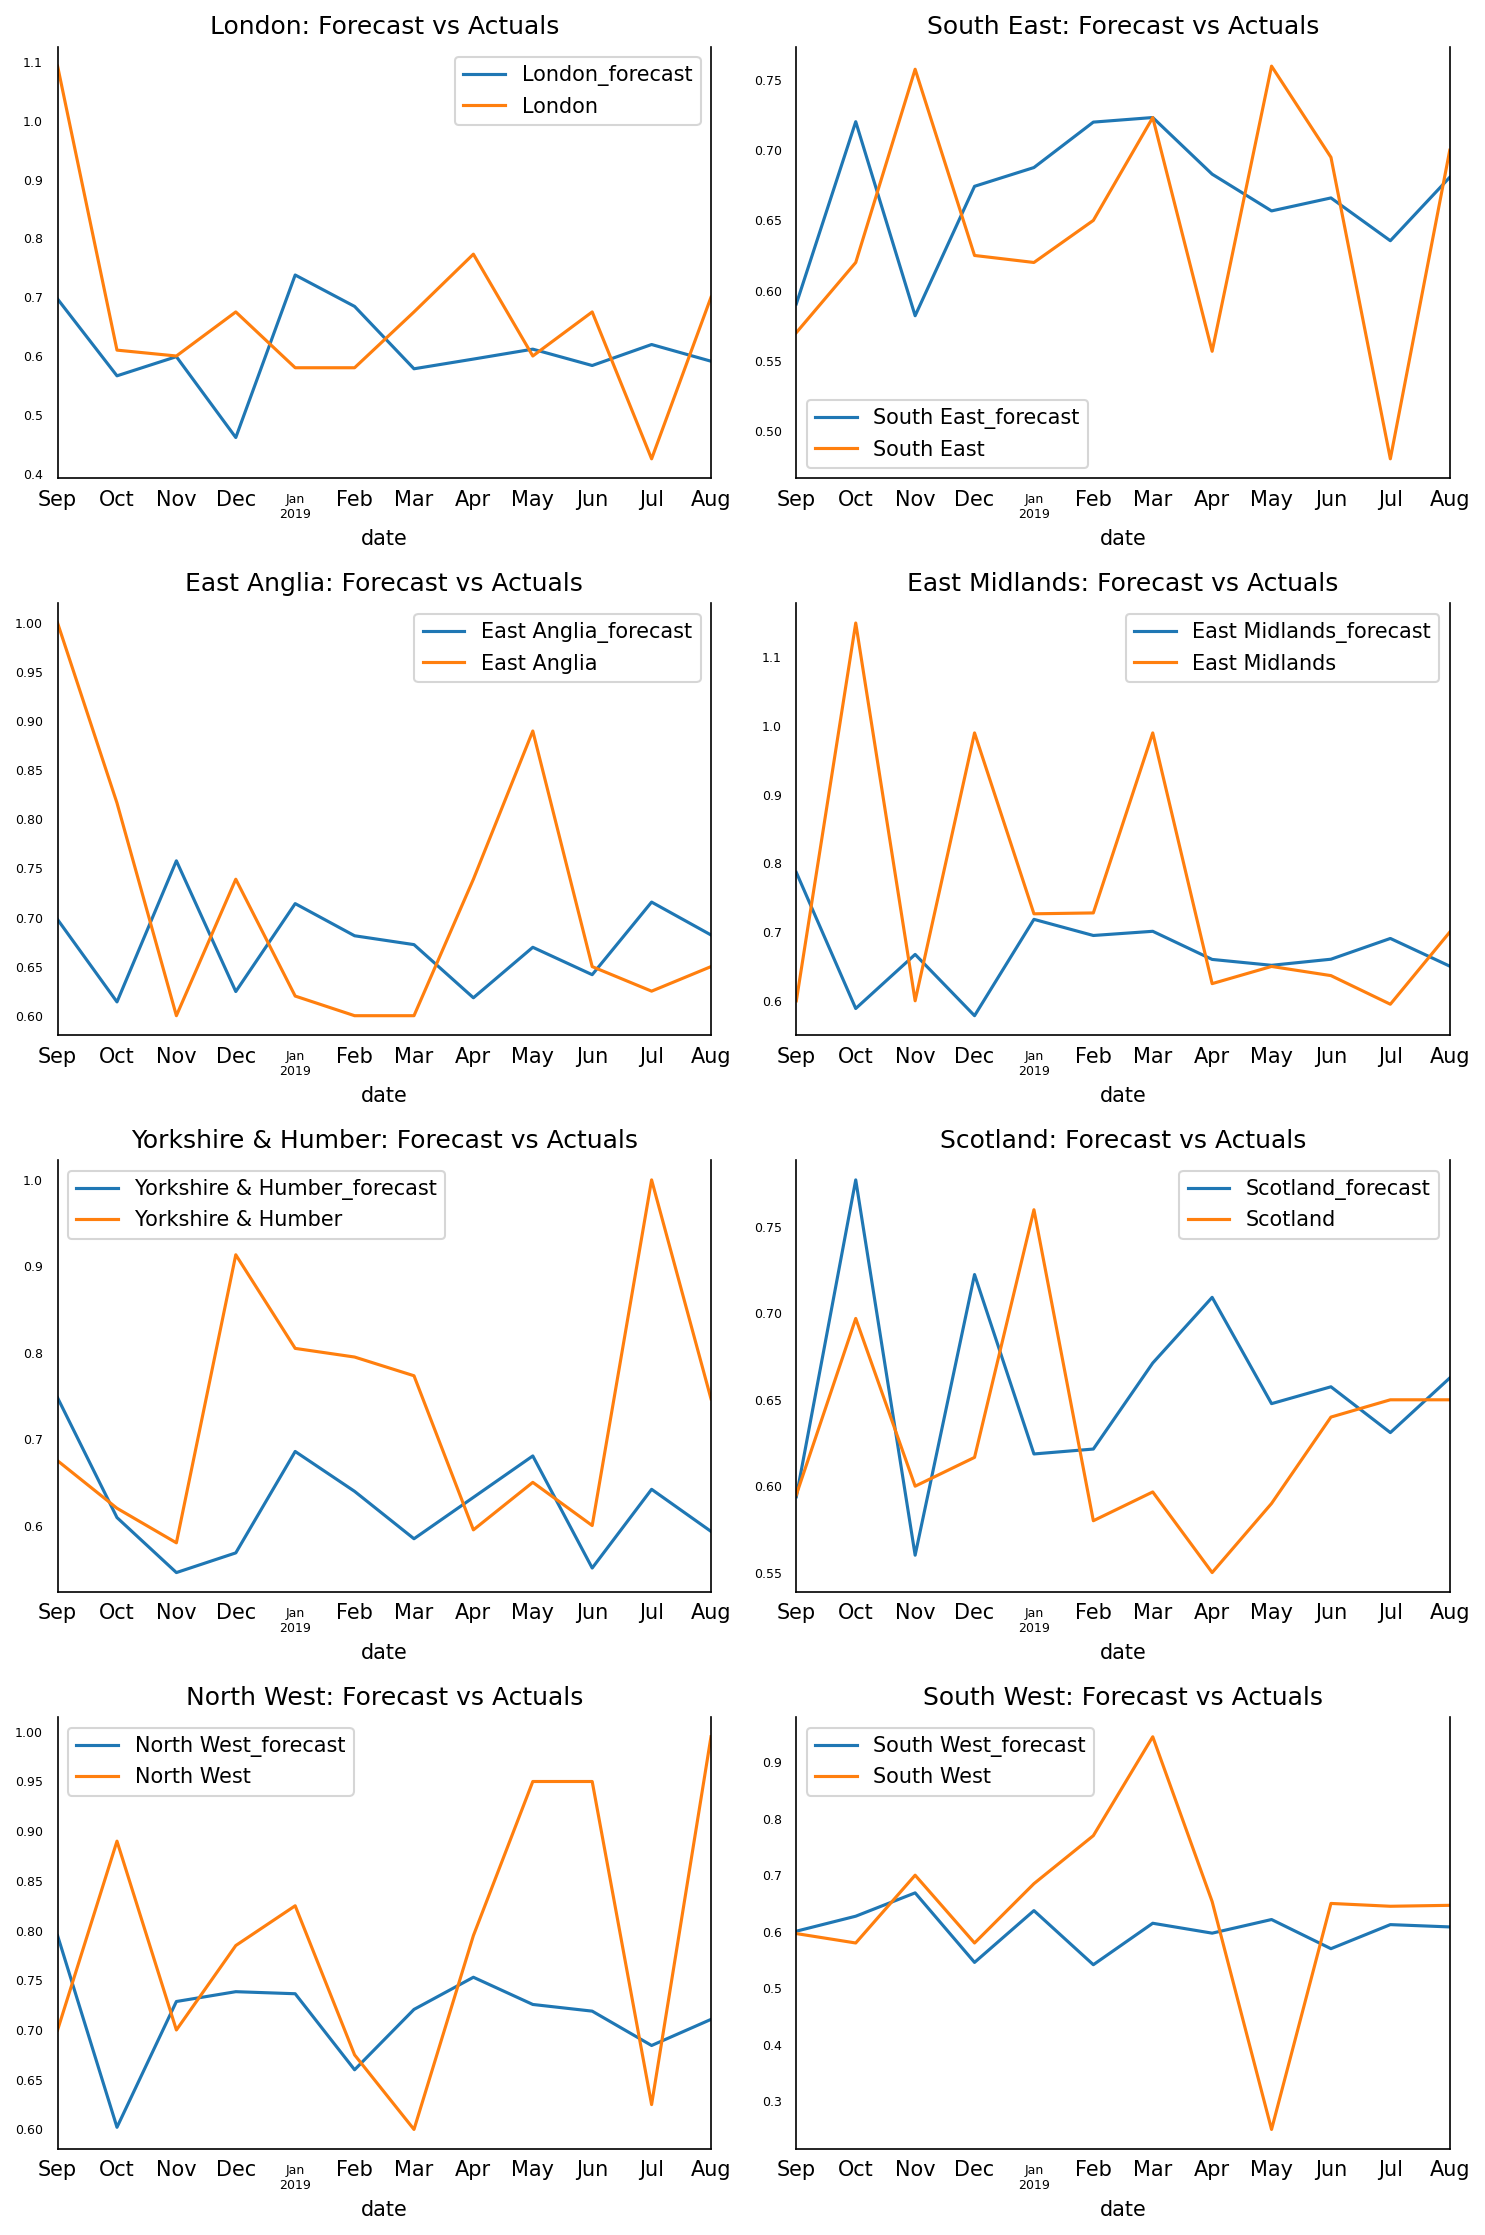

In [86]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=150, figsize=(10,15))
for i, (col,ax) in enumerate(zip(df_ts.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

Notice the forecast almost has a similar trend as the actual prices. Its no completely accurate. There could be other factors like weather conditions that the prediction did not take into consideration.

## **Evaluate the Forecasts**

In [87]:
# from statsmodels.tsa.stattools import acf
from sklearn.metrics import r2_score


def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    coefficient_of_dermination = r2_score(actual, forecast) #rsquared
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'rsquared':coefficient_of_dermination})

#### BIC

In [98]:
model_BIC = model.fit(1)

In [99]:
model_BIC.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 05, Aug, 2022
Time:                     18:04:05
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                   -31.1764
Nobs:                     365.000    HQIC:                  -31.7559
Log likelihood:           1293.98    FPE:                1.10327e-14
AIC:                     -32.1380    Det(Omega_mle):     8.65037e-15
--------------------------------------------------------------------
Results for equation London
                           coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------------
const                        -0.000486         0.009558           -0.051           0.959
L1.London                    -0.504561         0.048239          -10.460           0.000
L1.South East              

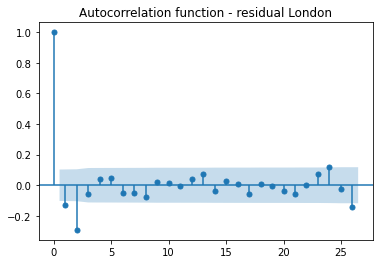

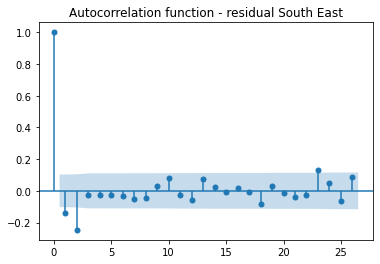

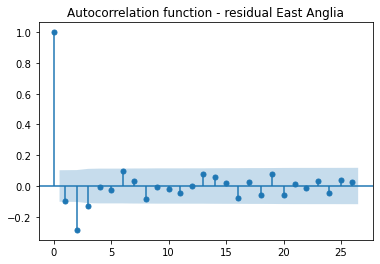

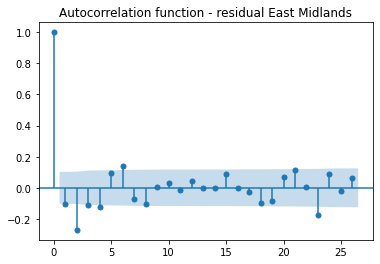

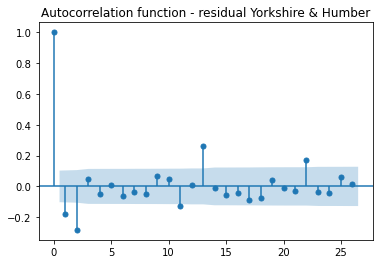

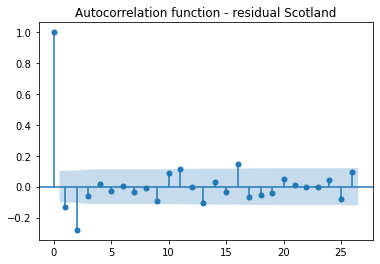

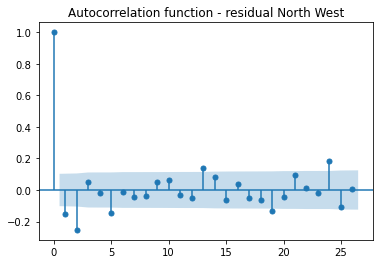

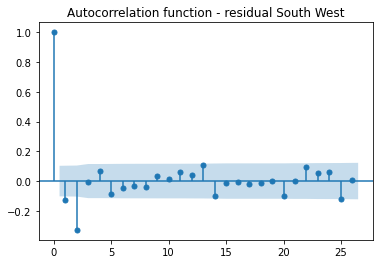

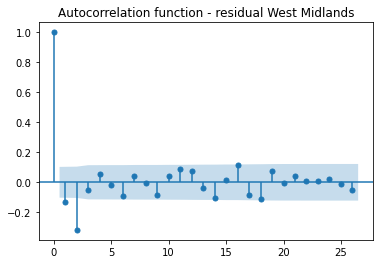

In [100]:
#Checking the presence of auto correlations in the residuals
for col in df_differenced.columns:
    plot_acf(model_BIC.resid[col],title='Autocorrelation function - residual {}'.format(col))

In [101]:
#Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
#The value of this statistic can vary between 0 and 4. 
#The closer it is to the value 2, then there is no significant serial correlation. 
#The closer to 0, there is a positive serial correlation, 
#and the closer it is to 4 implies negative serial correlation.


from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_BIC.resid)

for col, val in zip(df_differenced.columns, out):
    print(col, ':', round(val, 2))

London : 2.26
South East : 2.26
East Anglia : 2.2
East Midlands : 2.19
Yorkshire & Humber : 2.35
Scotland : 2.26
North West : 2.29
South West : 2.26
West Midlands : 2.26


In [102]:
lag_BIC = model_BIC.k_ar

In [103]:
lag_BIC

1

In [104]:
forecast_BIC = df_differenced.values[-lag_BIC:]
forecast_BIC

array([[ 0.08000004,  0.33333337, -0.18902802,  0.44500002, -0.13147175,
         0.35000002,  0.05995536,  0.05000001,  0.16674304]],
      dtype=float32)

In [105]:
# Forecast
fc_BIC = model_BIC.forecast(y=forecast_BIC, steps=nobs)
df_BIC = pd.DataFrame(fc_BIC, index=df_ts.index[-nobs:], columns=df_ts.columns + '_1d')
df_BIC

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d
date,,,,,,,,,
2018-09-01,0.050382,-0.149701,0.110414,-0.214686,0.107594,-0.169743,-0.031034,-0.045445,-6.030727e-02
2018-10-01,-0.068941,0.075402,-0.059701,0.102760,-0.076282,0.080783,0.019306,0.025938,2.313828e-02
2018-11-01,0.053761,-0.041207,0.029752,-0.048174,0.049694,-0.038155,-0.013904,-0.013585,-1.049352e-02
2018-12-01,-0.036030,0.024537,-0.014506,0.022758,-0.032640,0.017489,0.008963,0.005158,5.350231e-03
2019-01-01,0.021018,-0.014441,0.006349,-0.010290,0.019809,-0.008388,-0.006397,-0.002822,-3.236347e-03
2019-02-01,-0.012354,0.009161,-0.003144,0.005087,-0.012944,0.003781,0.003453,0.000317,1.706890e-03
2019-03-01,0.006108,-0.005174,0.001120,-0.002154,0.007114,-0.002142,-0.002553,-0.000872,-1.106805e-03
2019-04-01,-0.003712,0.003477,-0.000831,0.001365,-0.004923,0.000905,0.000933,-0.000401,4.136854e-04
2019-05-01,0.001378,-0.001687,0.000112,-0.000438,0.002153,-0.000763,-0.000998,-0.000618,-3.496542e-04


In [106]:
df_results_BIC = invert_transformation(df_train, df_BIC, second_diff=False)        


In [107]:
df_results_BIC 

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d,London_forecast,South East_forecast,East Anglia_forecast,East Midlands_forecast,Yorkshire & Humber_forecast,Scotland_forecast,North West_forecast,South West_forecast,West Midlands_forecast
date,,,,,,,,,,,,,,,,,,
2018-09-01,0.050382,-0.149701,0.110414,-0.214686,0.107594,-0.169743,-0.031034,-0.045445,-6.030727e-02,0.620382,0.693632,0.660414,0.710314,0.682594,0.680257,0.728966,0.504555,0.656436
2018-10-01,-0.068941,0.075402,-0.059701,0.102760,-0.076282,0.080783,0.019306,0.025938,2.313828e-02,0.551441,0.769034,0.600714,0.813074,0.606311,0.761040,0.748272,0.530493,0.679574
2018-11-01,0.053761,-0.041207,0.029752,-0.048174,0.049694,-0.038155,-0.013904,-0.013585,-1.049352e-02,0.605202,0.727827,0.630466,0.764900,0.656005,0.722885,0.734368,0.516908,0.669081
2018-12-01,-0.036030,0.024537,-0.014506,0.022758,-0.032640,0.017489,0.008963,0.005158,5.350231e-03,0.569172,0.752363,0.615960,0.787658,0.623365,0.740375,0.743331,0.522066,0.674431
2019-01-01,0.021018,-0.014441,0.006349,-0.010290,0.019809,-0.008388,-0.006397,-0.002822,-3.236347e-03,0.590189,0.737923,0.622309,0.777368,0.643174,0.731986,0.736934,0.519245,0.671194
2019-02-01,-0.012354,0.009161,-0.003144,0.005087,-0.012944,0.003781,0.003453,0.000317,1.706890e-03,0.577835,0.747084,0.619165,0.782455,0.630230,0.735768,0.740386,0.519562,0.672901
2019-03-01,0.006108,-0.005174,0.001120,-0.002154,0.007114,-0.002142,-0.002553,-0.000872,-1.106805e-03,0.583944,0.741910,0.620285,0.780301,0.637344,0.733626,0.737833,0.518690,0.671795
2019-04-01,-0.003712,0.003477,-0.000831,0.001365,-0.004923,0.000905,0.000933,-0.000401,4.136854e-04,0.580231,0.745387,0.619455,0.781666,0.632421,0.734531,0.738766,0.518289,0.672208
2019-05-01,0.001378,-0.001687,0.000112,-0.000438,0.002153,-0.000763,-0.000998,-0.000618,-3.496542e-04,0.581610,0.743700,0.619567,0.781228,0.634574,0.733768,0.737768,0.517671,0.671859


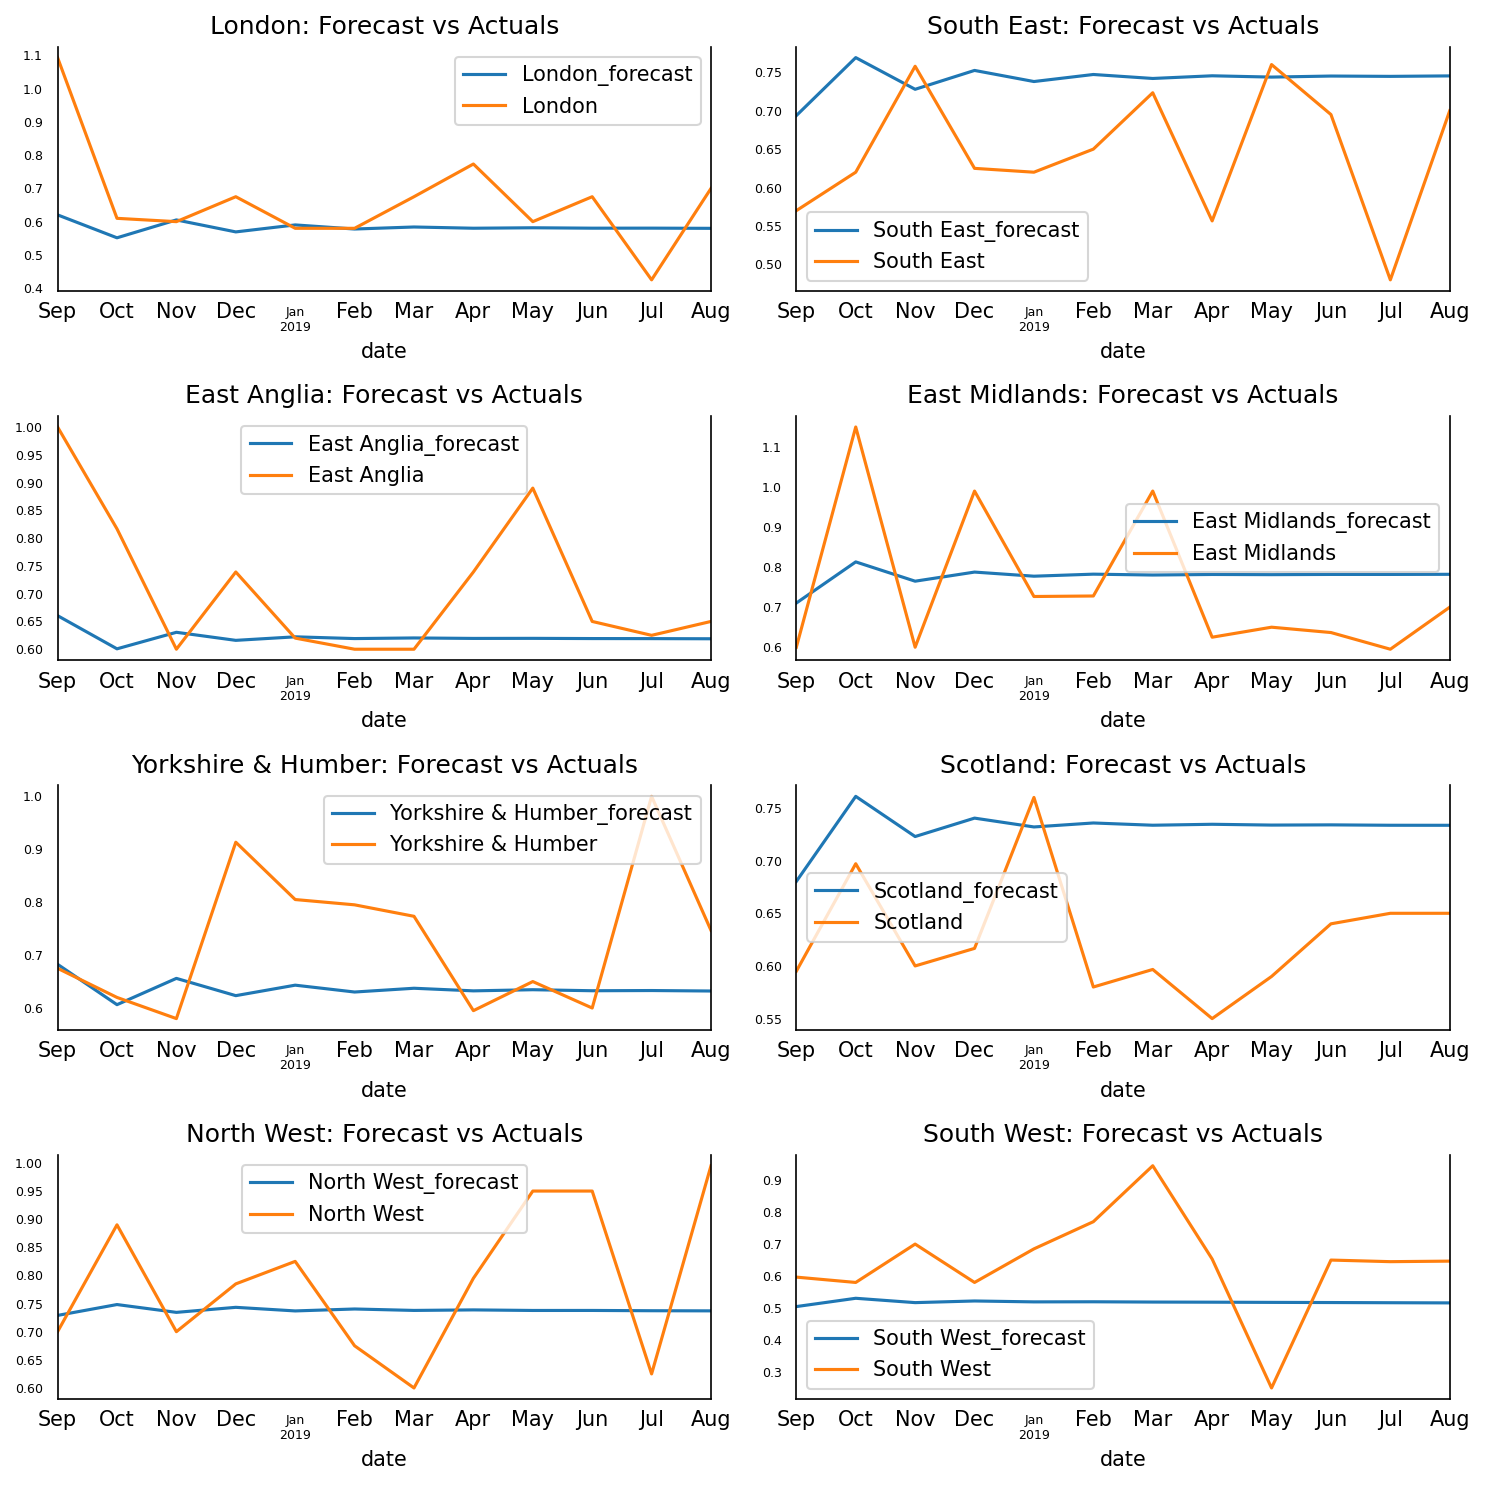

In [108]:
fig, axes = plt.subplots(nrows=int(len(df_ts.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_ts.columns, axes.flatten())):
    df_results_BIC[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### FPE

In [109]:
model_FPE = model.fit(6)

In [110]:
lag_FPE = model_FPE.k_ar

In [111]:
forecast_FPE = df_differenced.values[-lag_FPE:]
forecast_FPE

array([[ 6.1710894e-02, -6.6666603e-03, -2.9999971e-02,  2.0749998e-01,
         4.1666627e-02, -3.5292590e-01,  4.5000017e-02, -1.4500004e-01,
         5.0000012e-02],
       [-6.1710894e-02,  2.6778740e-01,  6.9999933e-02, -2.1749997e-01,
        -8.6666644e-02,  0.0000000e+00, -9.5000029e-02,  5.0166661e-01,
         1.2499994e-01],
       [ 2.2500038e-02,  1.3721257e-01, -4.8333287e-02,  1.0499996e-01,
        -9.0000004e-02, -1.9707406e-01,  4.4643879e-05, -5.1666659e-01,
        -1.7499995e-01],
       [ 3.9210856e-02, -3.6833334e-01, -2.3500001e-01, -1.6499999e-01,
         7.0000023e-02,  4.5000017e-02,  0.0000000e+00, -3.0000031e-02,
         2.9333335e-01],
       [-2.2171086e-01, -1.6666651e-02,  2.3902804e-01,  0.0000000e+00,
         1.5647179e-01, -4.5000017e-02,  0.0000000e+00, -1.9999981e-02,
        -2.4333334e-01],
       [ 8.0000043e-02,  3.3333337e-01, -1.8902802e-01,  4.4500002e-01,
        -1.3147175e-01,  3.5000002e-01,  5.9955359e-02,  5.0000012e-02,
         1.

In [113]:
# Forecast
fc_FPE = model_FPE.forecast(y=forecast_FPE, steps=nobs)
df_FPE = pd.DataFrame(fc_FPE, index=df_ts.index[-nobs:], columns=df_ts.columns + '_1d')
df_FPE

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d
date,,,,,,,,,
2018-09-01,0.094617,-0.265285,0.136657,-0.237122,0.155367,-0.224731,-0.015481,0.071896,-0.133097
2018-10-01,-0.033667,0.158330,-0.074537,-0.083976,-0.137692,0.074841,-0.045072,0.018417,-0.003143
2018-11-01,-0.023055,-0.097642,0.162720,0.086313,-0.025231,-0.126590,0.070256,0.051694,0.085829
2018-12-01,-0.115130,0.015865,-0.191742,-0.121889,-0.006199,0.098100,0.015571,-0.183672,-0.090443
2019-01-01,0.211501,0.014478,0.132742,0.100965,0.109178,-0.043324,-0.065954,0.162567,0.073596
2019-02-01,-0.021985,-0.003643,-0.041794,0.026885,-0.028461,0.005112,0.016698,-0.097328,0.002561
2019-03-01,-0.107408,0.049910,-0.040403,-0.016798,-0.050833,0.044272,-0.002458,0.036644,-0.004407
2019-04-01,0.045968,-0.052792,0.030154,-0.037260,0.061871,-0.012411,0.017876,-0.002320,-0.022865
2019-05-01,-0.022882,0.011303,-0.010535,0.008894,-0.015940,-0.013972,-0.014522,0.009461,-0.016133


In [114]:
df_results_FPE = invert_transformation(df_train, df_FPE, second_diff=False) 

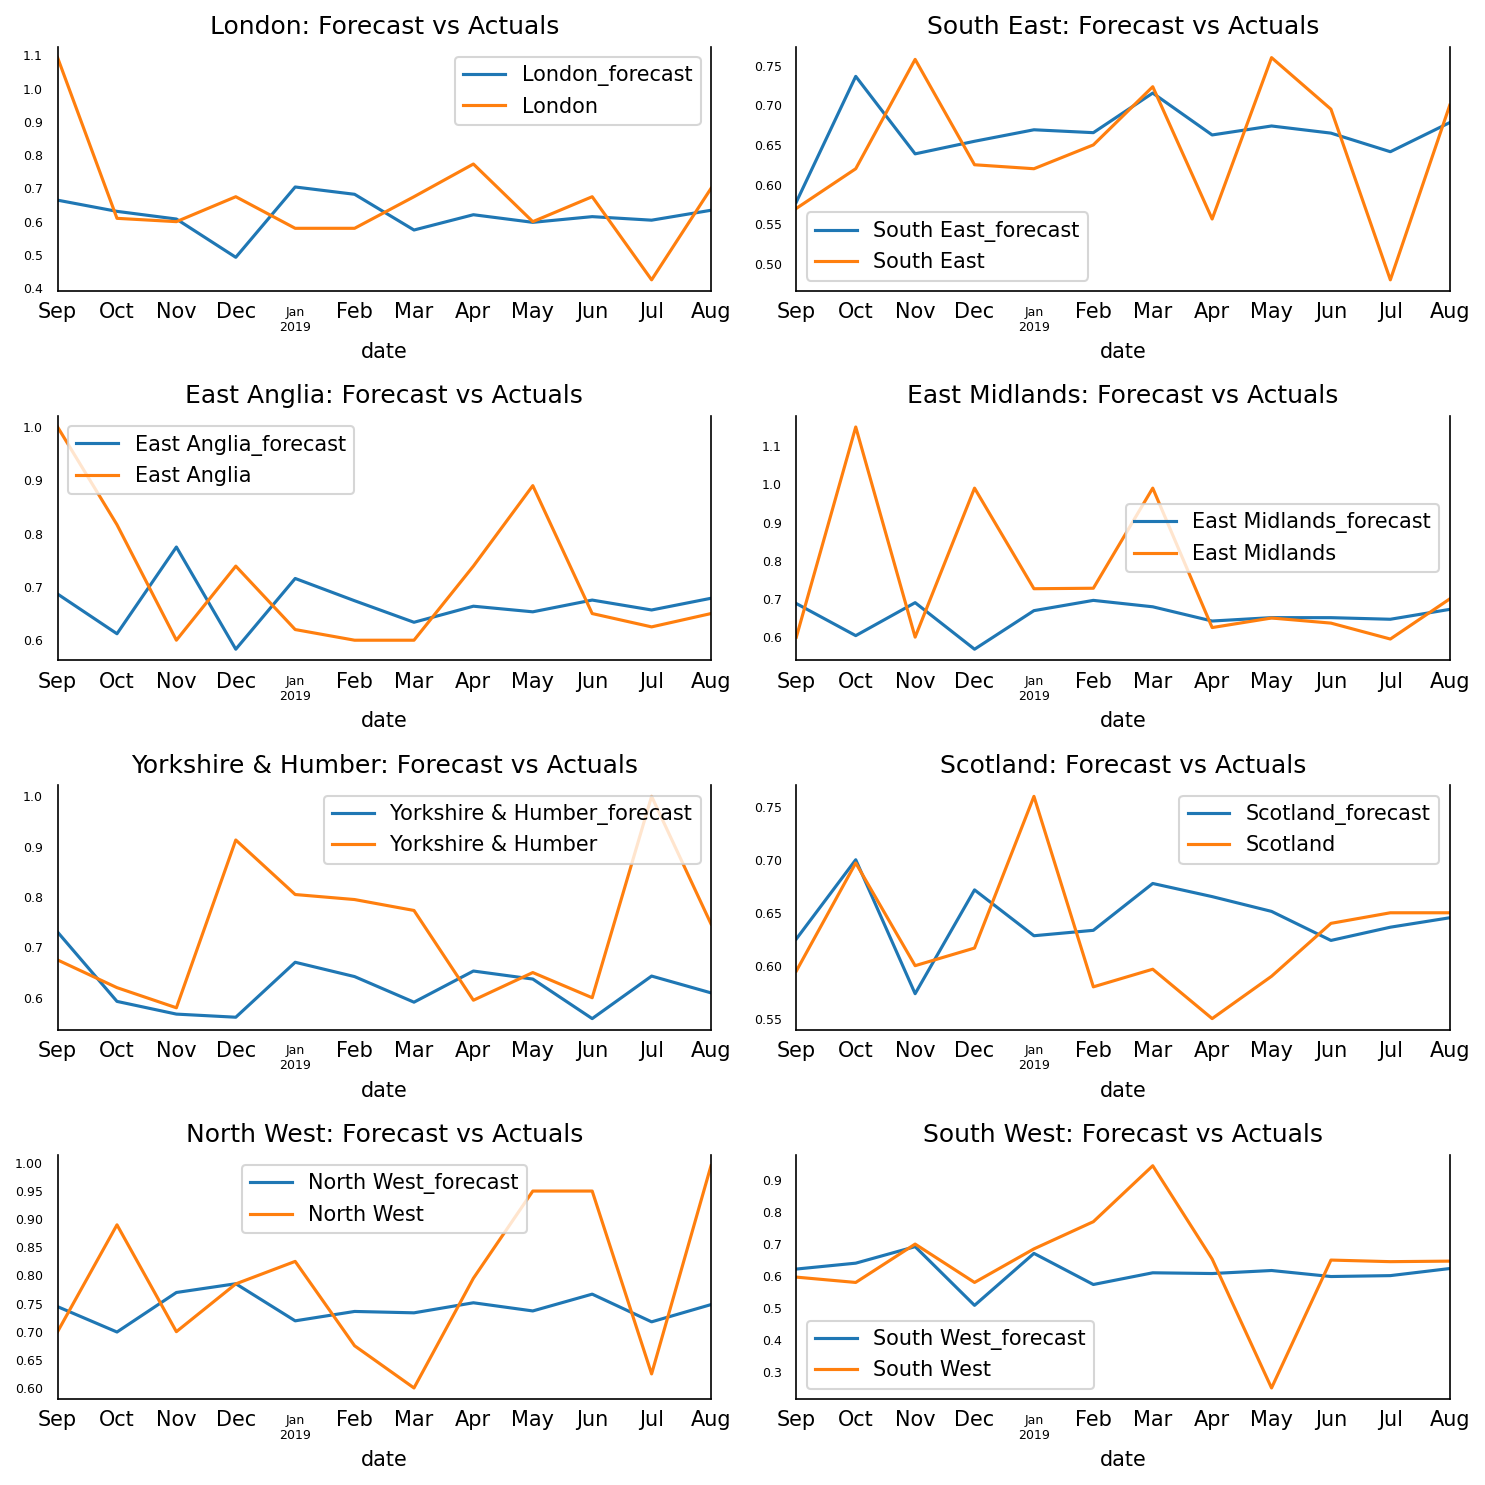

In [115]:
fig, axes = plt.subplots(nrows=int(len(df_ts.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_ts.columns, axes.flatten())):
    df_results_FPE[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

#### HQIC

In [116]:
model_HQ = model.fit(3)

In [117]:
lag_HQ = model_HQ.k_ar

In [118]:
forecast_HQ = df_differenced.values[-lag_HQ:]
forecast_HQ

array([[ 0.03921086, -0.36833334, -0.23500001, -0.16499999,  0.07000002,
         0.04500002,  0.        , -0.03000003,  0.29333335],
       [-0.22171086, -0.01666665,  0.23902804,  0.        ,  0.15647179,
        -0.04500002,  0.        , -0.01999998, -0.24333334],
       [ 0.08000004,  0.33333337, -0.18902802,  0.44500002, -0.13147175,
         0.35000002,  0.05995536,  0.05000001,  0.16674304]],
      dtype=float32)

In [119]:
# Forecast
fc_HQ = model_HQ.forecast(y=forecast_HQ, steps=nobs)
df_HQ = pd.DataFrame(fc_HQ, index=df_ts.index[-nobs:], columns=df_ts.columns + '_1d')
df_HQ

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d
date,,,,,,,,,
2018-09-01,0.201468,-0.140586,0.139398,-0.198108,0.164343,-0.230081,-0.025711,-0.005548,-0.027302
2018-10-01,-0.110972,0.069350,-0.112723,-0.098027,-0.136018,0.026006,-0.008034,0.087224,0.005912
2018-11-01,-0.026757,-0.095367,0.082451,0.107173,0.001351,0.031800,0.048029,-0.082463,-0.007050
2018-12-01,-0.009878,0.049434,-0.031814,-0.040289,0.073612,0.008228,-0.039957,-0.030958,-0.007519
2019-01-01,0.063615,-0.006921,0.008155,0.027999,-0.032413,-0.015893,0.018900,0.056528,-0.001915
2019-02-01,-0.040736,0.010635,-0.016294,-0.020117,-0.012609,-0.017635,-0.016168,0.002107,0.009695
2019-03-01,0.002085,-0.010374,0.009038,0.002582,0.000075,0.020223,0.011040,-0.020542,0.000737
2019-04-01,0.002333,-0.003181,0.004523,-0.002006,0.017714,0.000730,-0.001458,-0.007880,-0.001962
2019-05-01,0.007474,0.003412,-0.003065,0.007568,-0.012095,-0.002292,0.000726,0.014437,-0.008082


In [120]:
df_results_HQ = invert_transformation(df_train, df_HQ, second_diff=False) 

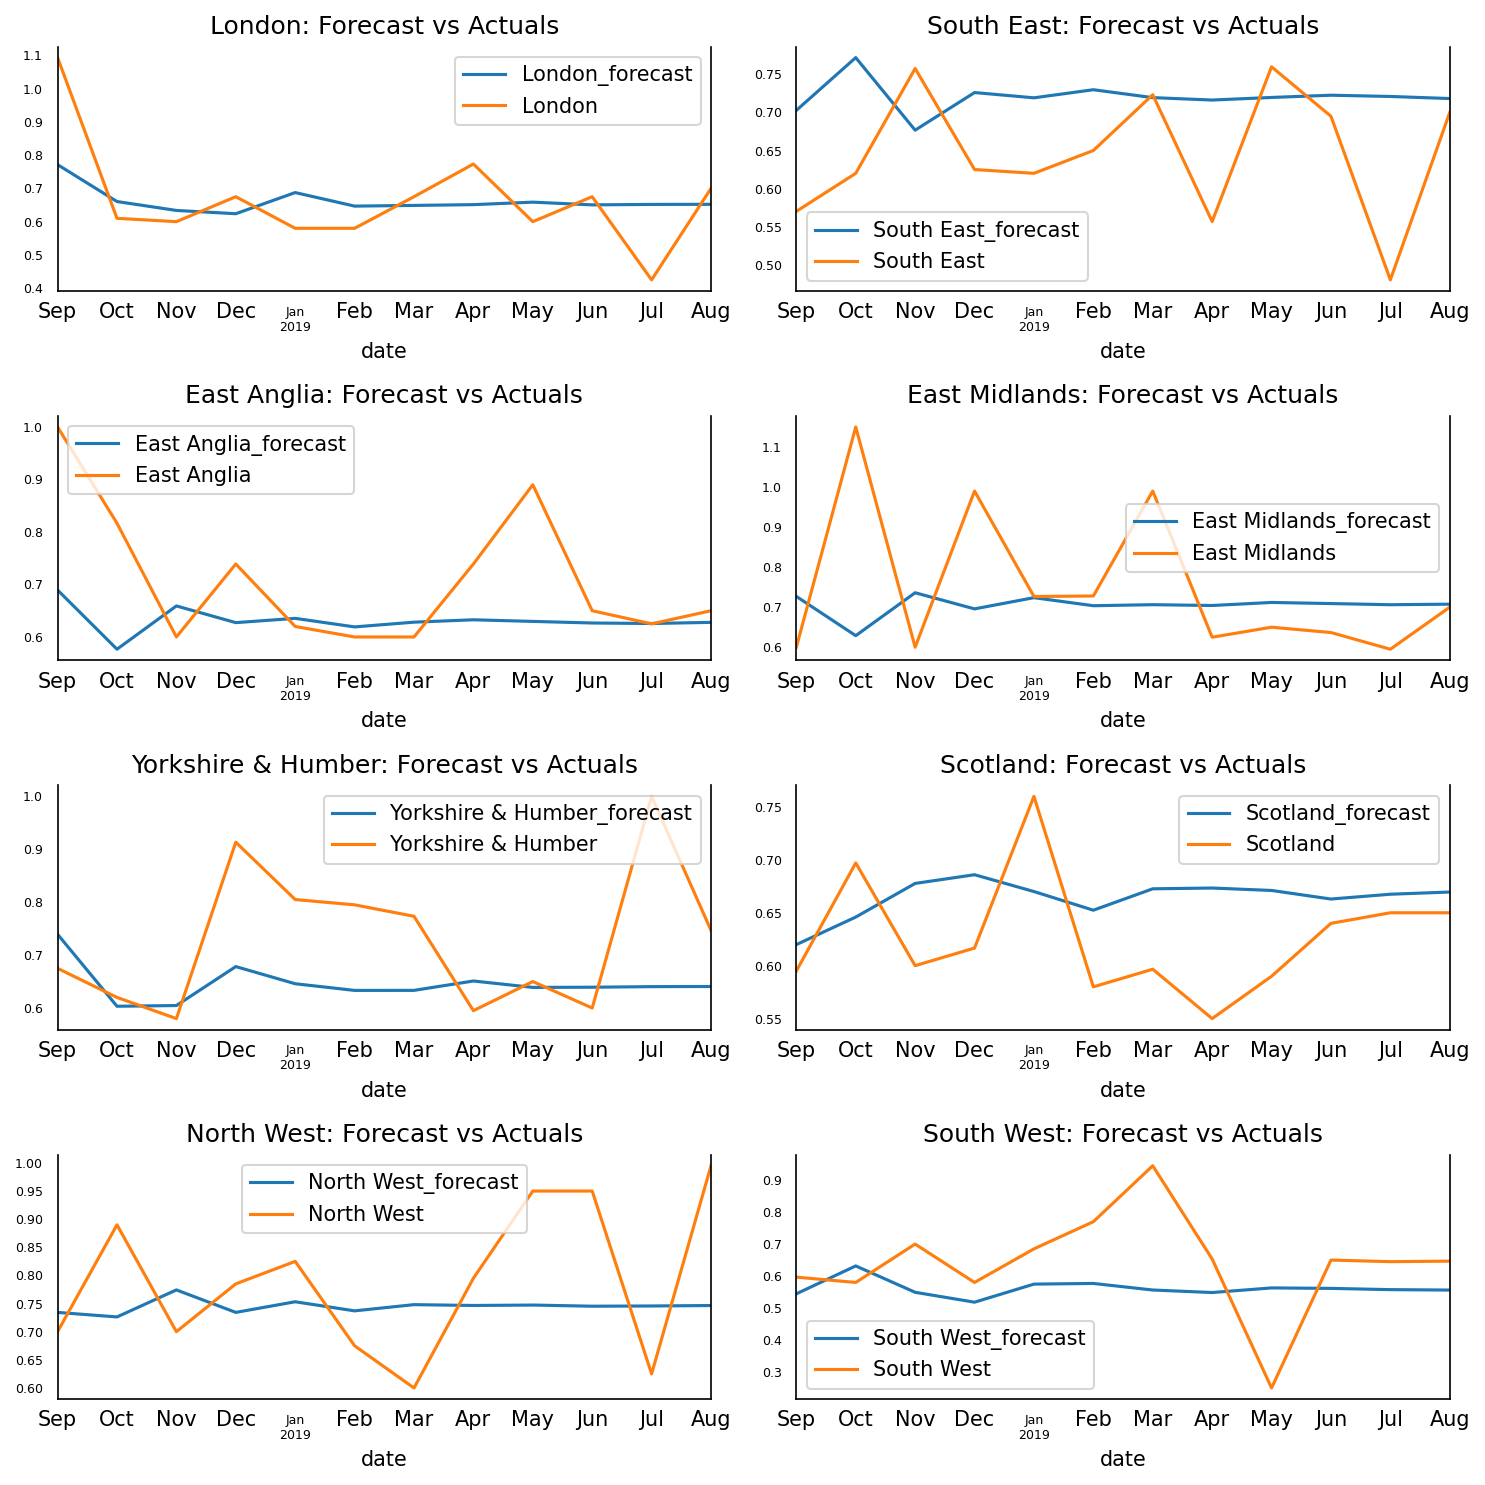

In [121]:
fig, axes = plt.subplots(nrows=int(len(df_ts.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df_ts.columns, axes.flatten())):
    df_results_HQ[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [122]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse})

#### MAPE

One of the most common metrics used to measure the forecasting accuracy of a model is MAPE, which stands for mean absolute percentage error.

The formula to calculate MAPE is as follows:

MAPE = (1/n) * Σ(|actual – forecast| / |actual|) * 100

where:

- Σ – a fancy symbol that means “sum”
- n – sample size
- actual – the actual data value
- forecast – the forecasted data value

In [123]:
models = [model_fitted,model_BIC,model_FPE,model_HQ]

In [124]:
def forecast_mape(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))
    return mape

In [125]:
invert_transformation(df_train, df_BIC, second_diff=False)

,London_1d,South East_1d,East Anglia_1d,East Midlands_1d,Yorkshire & Humber_1d,Scotland_1d,North West_1d,South West_1d,West Midlands_1d,London_forecast,South East_forecast,East Anglia_forecast,East Midlands_forecast,Yorkshire & Humber_forecast,Scotland_forecast,North West_forecast,South West_forecast,West Midlands_forecast
date,,,,,,,,,,,,,,,,,,
2018-09-01,0.050382,-0.149701,0.110414,-0.214686,0.107594,-0.169743,-0.031034,-0.045445,-6.030727e-02,0.620382,0.693632,0.660414,0.710314,0.682594,0.680257,0.728966,0.504555,0.656436
2018-10-01,-0.068941,0.075402,-0.059701,0.102760,-0.076282,0.080783,0.019306,0.025938,2.313828e-02,0.551441,0.769034,0.600714,0.813074,0.606311,0.761040,0.748272,0.530493,0.679574
2018-11-01,0.053761,-0.041207,0.029752,-0.048174,0.049694,-0.038155,-0.013904,-0.013585,-1.049352e-02,0.605202,0.727827,0.630466,0.764900,0.656005,0.722885,0.734368,0.516908,0.669081
2018-12-01,-0.036030,0.024537,-0.014506,0.022758,-0.032640,0.017489,0.008963,0.005158,5.350231e-03,0.569172,0.752363,0.615960,0.787658,0.623365,0.740375,0.743331,0.522066,0.674431
2019-01-01,0.021018,-0.014441,0.006349,-0.010290,0.019809,-0.008388,-0.006397,-0.002822,-3.236347e-03,0.590189,0.737923,0.622309,0.777368,0.643174,0.731986,0.736934,0.519245,0.671194
2019-02-01,-0.012354,0.009161,-0.003144,0.005087,-0.012944,0.003781,0.003453,0.000317,1.706890e-03,0.577835,0.747084,0.619165,0.782455,0.630230,0.735768,0.740386,0.519562,0.672901
2019-03-01,0.006108,-0.005174,0.001120,-0.002154,0.007114,-0.002142,-0.002553,-0.000872,-1.106805e-03,0.583944,0.741910,0.620285,0.780301,0.637344,0.733626,0.737833,0.518690,0.671795
2019-04-01,-0.003712,0.003477,-0.000831,0.001365,-0.004923,0.000905,0.000933,-0.000401,4.136854e-04,0.580231,0.745387,0.619455,0.781666,0.632421,0.734531,0.738766,0.518289,0.672208
2019-05-01,0.001378,-0.001687,0.000112,-0.000438,0.002153,-0.000763,-0.000998,-0.000618,-3.496542e-04,0.581610,0.743700,0.619567,0.781228,0.634574,0.733768,0.737768,0.517671,0.671859


In [126]:
mape_df = pd.DataFrame(columns = df_test.columns,index = models )
for model in models:
    lag = model.k_ar
    forecast = df_differenced.values[-lag:]
    fc = model.forecast(y=forecast, steps=nobs)
    df = pd.DataFrame(fc, index=df_ts.index[-nobs:], columns=df_ts.columns + '_1d')
    results = invert_transformation(df_train, df, second_diff=False)
    for col in df_test.columns:
        val = forecast_mape(results[col+'_forecast'].values, df_test[col])
        
        mape_df.loc[model, col] = val

In [127]:
mape_df.index = ['AIC','BIC','FPE','HQIC']

In [128]:
mape_df

,London,South East,East Anglia,East Midlands,Yorkshire & Humber,Scotland,North West,South West,West Midlands
AIC,0.195576,0.123468,0.166219,0.167003,0.1588,0.100102,0.150213,0.226058,0.165765
BIC,0.150682,0.176192,0.121775,0.202012,0.143949,0.179884,0.141036,0.291856,0.130524
FPE,0.17117,0.102891,0.158484,0.150947,0.154632,0.079713,0.140558,0.219401,0.147556
HQIC,0.145206,0.161929,0.122128,0.170464,0.140209,0.098539,0.146811,0.262114,0.121971


#### RMSE

In [129]:
def forecast_rmse(forecast, actual):
    rmse = np.mean((forecast - actual)**2)**.5
    return rmse

**Normalizing the RMSE Value**

One way to gain a better understanding of whether a certain RMSE value is “good” is to normalize it using the following formula:

Normalized RMSE = RMSE / (max value – min value)

This produces a value between 0 and 1, where values closer to 0 represent better fitting models.

In [132]:
rmse_df = pd.DataFrame(columns = df_test.columns,index = models )
for model in models:
    lag = model.k_ar
    forecast = df_differenced.values[-lag:]
    fc = model.forecast(y=forecast, steps=nobs)
    df = pd.DataFrame(fc, index=df_ts.index[-nobs:], columns=df_ts.columns + '_1d')
    results = invert_transformation(df_train, df, second_diff=False)
    for col in df_test.columns:
        val = forecast_rmse(results[col+'_forecast'].values, df_test[col])
        normal = (val)/(df_train[col].max() - df_train[col].min()) #normalizing rmse 
        rmse_df.loc[model, col] = normal

In [133]:
rmse_df.index = ['AIC','BIC','FPE','HQIC']
rmse_df

,London,South East,East Anglia,East Midlands,Yorkshire & Humber,Scotland,North West,South West,West Midlands
AIC,0.124672,0.078069,0.129415,0.136322,0.137807,0.077283,0.169322,0.140318,0.148042
BIC,0.123195,0.104516,0.130567,0.101939,0.129083,0.113185,0.145622,0.168933,0.111828
FPE,0.120358,0.066946,0.132183,0.133517,0.137433,0.06199,0.145294,0.136859,0.139274
HQIC,0.095462,0.096258,0.126451,0.122431,0.121484,0.066443,0.146055,0.150353,0.103908


Base on the plots and normalised RMSE the best performing models are the AIC and FPE. They both follow the trend even if its not accurate and they both have low RMSE.

### CONCLUSION

The models have drawbacks they are not as accurate as we would have liked. The models don't consider real life events that can afffect the price of lettuce. The models only predict the price at the beginning of the month. The models  follow the trend of price flactuation but the gap between the forecast and actual values is bigger than expected. Going forward these will be the considerations to improve the models.